## Creating Target using KMeans

#### Load Libraries

In [41]:
import pandas as pd
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 1000
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot import TPOTClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
%matplotlib inline

#### Create a target variable based on results of k-means clustering , and use it as target for classification

In [67]:
#Load Target data :
surrounding_pdf = pd.read_csv('../UseCase_3_Datasets/store_surrounding_pdf_exp.csv')
store_sales = pd.read_csv('../UseCase_3_Datasets/sales_per_day_period.csv')

#print(store_sales.shape)

sales_pdf_daily_sub = store_sales[store_sales['store_code'].isin(surrounding_pdf['store_code'])]

#print(sales_pdf_daily_sub.shape)

X = sales_pdf_daily_sub[['total_sales','Morning','Afternoon','Evening','sales_per_hr']]
X['total_sales'] = sales_pdf_daily_sub['total_sales'].apply(lambda x : np.log(x))

normalizedX = X


/Users/anilkumarpanda/SoftwareInstalls/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

In [69]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(normalizedX)
y_kmeans = kmeans.predict(normalizedX)

In [70]:
pca = PCA(n_components=2).fit(normalizedX)
pca_nx = pca.transform(normalizedX)

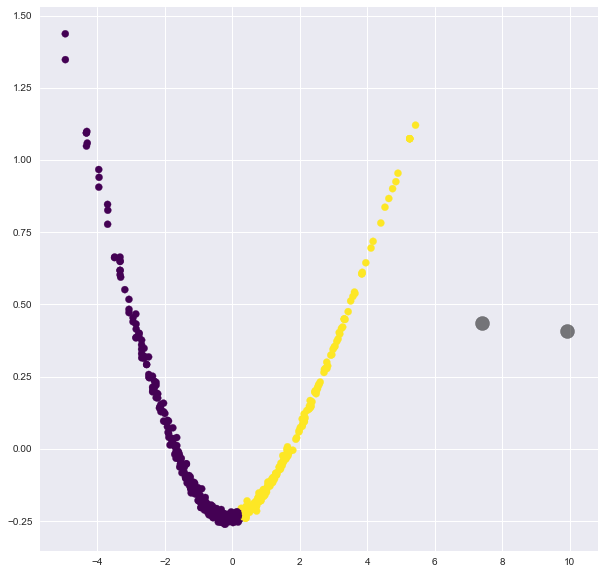

In [71]:
plt.figure(figsize=(10,10))
plt.scatter(pca_nx[:,0],pca_nx[:,1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black',s=200, alpha=0.5)
plt.show()

In [72]:
sales_pdf_daily_sub['y_kmeans'] = y_kmeans

/Users/anilkumarpanda/SoftwareInstalls/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [73]:
sales_pdf_daily_sub = sales_pdf_daily_sub[['store_code','y_kmeans']]
sales_pdf_daily_sub.head()

,store_code,y_kmeans
0,10055,1
1,10077,0
2,10079,1
5,10086,1
6,10111,1


In [75]:
print("Surrounding Shape",surrounding_pdf.shape)
print("Sales Shape",sales_pdf_daily_sub.shape)

Surrounding Shape (534, 183)
Sales Shape (535, 2)


In [76]:
#Join Store and Surroounding datasets
sales_surrounding_pdf = pd.merge(sales_pdf_daily_sub,surrounding_pdf,on='store_code',how='inner')
sales_surrounding_pdf = sales_surrounding_pdf.drop_duplicates()
# Dropping columns that do not provide useful information for this analysis
for i in sales_surrounding_pdf.columns:
    if sales_surrounding_pdf[i].nunique() == 1:
        sales_surrounding_pdf.drop(i, axis = 1, inplace = True)
print("Sales Surrounding Shape",sales_surrounding_pdf.shape)

Sales Surrounding Shape (533, 179)


In [77]:
import math
#One hot Encoding for city values
sales_surrounding_pdf_ohe = pd.get_dummies(sales_surrounding_pdf)
#Create Train,Test without imputation
#X = sales_surrounding_pdf.loc[:, sales_surrounding_pdf.columns != 'total_sales']
#X = sales_surrounding_pdf.loc[:, sales_surrounding_pdf.columns != 'store_code']

y = sales_surrounding_pdf_ohe['y_kmeans']
X = sales_surrounding_pdf_ohe.drop(['y_kmeans','store_code'],axis=1)
#X = sales_surrounding_pdf.drop('store_code',axis=1)

from sklearn.preprocessing import Normalizer

scaler = Normalizer().fit(X)
normalizedX = scaler.transform(X)

print("Shape ",X.shape)
print ("Shape ",y.shape)

Shape  (533, 211)
Shape  (533,)


In [78]:
#Divide into train and test
validation_size = 0.30
seed = 33
X_train, X_test, y_train, y_test = train_test_split(normalizedX, y,test_size=validation_size,random_state=seed)

In [83]:
# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
seed = 19
dtree_model = DecisionTreeClassifier(max_depth = 3,random_state=seed).fit(X_train, y_train)

dtree_predictions_train = dtree_model.predict(X_train)
dtree_predictions = dtree_model.predict(X_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, dtree_predictions)
print(cm)

[[80 18]
 [33 29]]


In [84]:
import numpy as np
from sklearn.metrics import roc_auc_score
print("Train :",roc_auc_score(y_train, dtree_predictions_train))
print("Test :",roc_auc_score(y_test, dtree_predictions))

Train : 0.72518398587
Test : 0.642034233048


In [85]:
def visualize_tree(tree,feature_names,file_name):
    """Create tree png using graphviz.
    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open(file_name, 'w') as f:
        export_graphviz(tree, out_file=f,feature_names=feature_names)
    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to produce visualization")

visualize_tree(dtree_model,X.columns,"dt_tree_kmeans.txt")

In [86]:
from sklearn.model_selection import GridSearchCV

seed = 17
dtcf = DecisionTreeClassifier(max_depth=1,random_state=seed) 

param_grid = { 
    
    'max_depth': list(range(1,10,1)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split' : list(range(2,20,1)),
     'criterion':['entropy','gini']
}

CV_dtcf = GridSearchCV(estimator=dtcf,param_grid=param_grid,cv=10,scoring='roc_auc')
CV_dtcf.fit(X_train, y_train)

print (CV_dtcf.best_params_)
print (CV_dtcf.best_score_)

predictions_train = CV_dtcf.best_estimator_.fit(X_train, y_train).predict(X_train)
print("Train :",roc_auc_score(y_train, predictions_train))


predictions = CV_dtcf.best_estimator_.predict(X_test)
print("Test :",roc_auc_score(y_test, predictions))

visualize_tree(CV_dtcf.best_estimator_,X.columns,"CV_dtcf.best_estimator_kmeans.txt")

{'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 10}
0.617272495155
Train : 0.614350897851
Test : 0.61866359447
